# Object Detection with DETR in PyTorch

In [1]:
from PIL import Image 
import requests 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format = 'retina'

import torch 
from torch import nn 
from torchvision.models import resnet50
import torchvision.transforms as T 

torch.set_grad_enabled(False)

import numpy as np 
import os 

np.random.seed(42)

In [8]:
class DETRDemo(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc 

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linea _bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                                self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [9]:
detr = DETRDemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval()

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /home/toanmh/.cache/torch/checkpoints/detr_demo-da2a99e9.pth
100%|██████████| 79.3M/79.3M [00:07<00:00, 10.7MB/s]


affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [10]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [11]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800,),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 *w), (y_c - 0.5 * h),
        (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

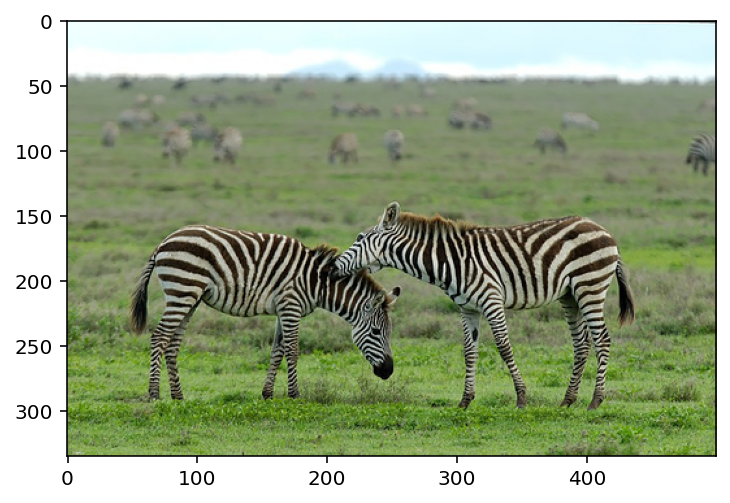

In [58]:
# Load image
url = 'http://images.cocodataset.org/test-stuff2017/000000015828.jpg'
im = Image.open(requests.get(url, stream=True).raw)
im2 = im.copy()
plt.imshow(im)

In [14]:
img = transform(im).unsqueeze(0).cuda()

# propagate through the model
outputs = detr(img)

print(outputs['pred_logits'].shape)
print('Number of bounding boxes: {}'.format(outputs['pred_boxes'].shape))

torch.Size([1, 100, 92])
Number of bounding boxes: torch.Size([1, 100, 4])


In [40]:
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
print(probas.shape)

torch.Size([100, 91])


In [41]:
keep = probas.max(-1).values > 0.7
print(keep.shape)
print([0, keep])

torch.Size([100])
[0, tensor([False, False, False, False,  True, False, False, False,  True, False,
        False, False, False,  True, False, False, False, False,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False,  True, False, False, False, False, False, False, False])]


In [42]:
print(outputs['pred_boxes'][0, keep])

tensor([[0.3038, 0.6747, 0.4227, 0.4152],
        [0.2480, 0.2857, 0.0472, 0.0905],
        [0.7411, 0.2767, 0.0563, 0.0703],
        [0.6415, 0.6571, 0.4679, 0.4898],
        [0.1676, 0.2864, 0.0475, 0.0905],
        [0.2069, 0.2552, 0.0560, 0.0480],
        [0.9738, 0.3068, 0.0521, 0.1019],
        [0.6201, 0.2216, 0.0671, 0.0610]])


In [45]:
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

In [50]:
bboxes_scaled.tolist()

[[46.20744323730469, 156.47787475585938, 257.5462951660156, 295.5704345703125],
 [112.1753158569336, 80.55931091308594, 135.7805938720703, 110.88456726074219],
 [356.48443603515625,
  80.92997741699219,
  384.6478271484375,
  104.48688507080078],
 [203.7574005126953, 138.0967254638672, 437.703125, 302.16717529296875],
 [71.92066192626953, 80.77322387695312, 95.65132904052734, 111.10380554199219],
 [89.46764373779297, 77.4503173828125, 117.46583557128906, 93.53286743164062],
 [473.8870544433594, 85.71600341796875, 499.9190368652344, 119.86162567138672],
 [293.2818908691406, 64.0048599243164, 326.8165283203125, 84.44734954833984]]

In [51]:
from PIL import Image, ImageDraw


tensor(24)
tensor(24)
tensor(24)
tensor(24)
tensor(24)
tensor(24)
tensor(24)
tensor(24)


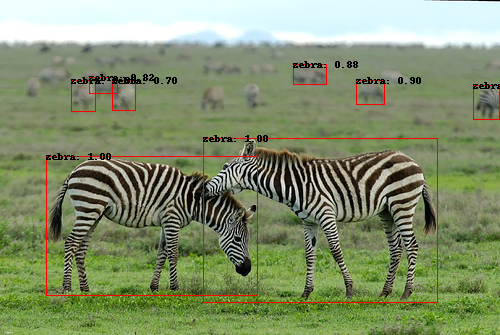

In [63]:
draw_img = ImageDraw.Draw(im2)
for p, (xmin, ymin, xmax, ymax), c in zip(probas[keep], bboxes_scaled.tolist(), COLORS * 100):
    cl = p.argmax()
    print(cl)
    text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
    draw_img.rectangle([(xmin, ymin), (xmax, ymax)], fill=None, outline='red')
    draw_img.text((xmin, ymin - 5), text, fill=True, color='yellow')

im2

In [68]:
print(probas[keep].argmax())

tensor(24)
